# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing, BatchNorm
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import random

In [2]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [3]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

Processing...
Done!


In [4]:
node_of_interest = random.randint(0, data.num_nodes - 1)
print("Node of Interest:", node_of_interest)

# extract 2-hop subgraph
subset_nodes, sub_edge_index, _, _ = k_hop_subgraph(
    node_of_interest, 
    num_hops=2, 
    edge_index=data.edge_index, 
    relabel_nodes=True
)

sub_x = data.x[subset_nodes]
sub_y = data.y[subset_nodes]

print("Subgraph Nodes:", sub_x.size(0))

Node of Interest: 896
Subgraph Nodes: 6


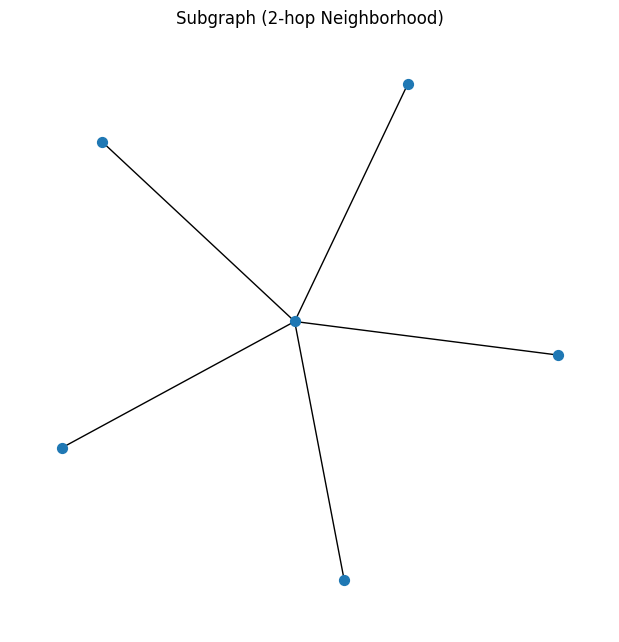

In [5]:
G = to_networkx(
    Data(x=sub_x, edge_index=sub_edge_index), 
    to_undirected=True
)

plt.figure(figsize=(6,6))
nx.draw(G, node_size=50)
plt.title("Subgraph (2-hop Neighborhood)")
plt.show()

In [6]:
#Jumlah Node
data.num_nodes

2708

In [7]:
#jumlah edge
data.num_edges

10556

In [8]:
#dimensi fitur
data.num_features

1433

In [9]:
#jumlah keasl
dataset.num_classes

7

In [10]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [11]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [12]:
class_counts = data.y.bincount()
for class_idx in range(len(class_counts)):
    print(f"Kelas {class_idx}: {class_counts[class_idx].item()} nodes")

Kelas 0: 351 nodes
Kelas 1: 217 nodes
Kelas 2: 418 nodes
Kelas 3: 818 nodes
Kelas 4: 426 nodes
Kelas 5: 298 nodes
Kelas 6: 180 nodes


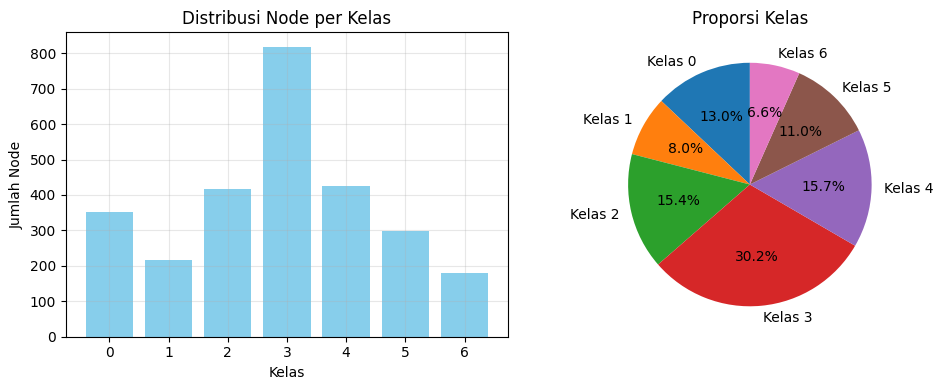

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(class_counts)), class_counts.numpy(), color='skyblue')
plt.title('Distribusi Node per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Node')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(class_counts.numpy(), labels=[f'Kelas {i}' for i in range(len(class_counts))], 
        autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Kelas')

plt.tight_layout()
plt.show()

In [14]:
#train nodes
data.train_mask.sum().item()

140

In [15]:
print(f"\nTrain ratio: {data.train_mask.sum().item()/data.num_nodes:.2%}")


Train ratio: 5.17%


In [16]:
#validation nodes
data.val_mask.sum().item()

500

In [17]:
print(f"Validation ratio: {data.val_mask.sum().item()/data.num_nodes:.2%}")

Validation ratio: 18.46%


In [18]:
#test nodes
data.test_mask.sum().item()

1000

In [19]:
print(f"Test ratio: {data.test_mask.sum().item()/data.num_nodes:.2%}")

Test ratio: 36.93%


In [20]:
data.edge_index.shape

torch.Size([2, 10556])

In [21]:
data.edge_index[:, :5]

tensor([[ 633, 1862, 2582,    2,  652],
        [   0,    0,    0,    1,    1]])

In [22]:
data.x[0, :10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# PRA-PROSES (Message Passing Layer)

$h_u^{(k)} = \sum W_{\text{msg}} \cdot h_u^{(k-1)} + W_{\text{self}} \cdot h_v^{(k-1)}$

 di mana,
 1. **k** adalah urutan lapisan GNN.
 2. **Wmsg** adalah bobot yang diakses bersama dengan neighborhood nodes.
 3. **Wself** adalah bobot milik node asal (v).

In [23]:
class CustomMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.W_msg = nn.Linear(in_channels, out_channels)  # For neighbors
        self.W_self = nn.Linear(in_channels, out_channels) # For self
        
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.W_msg(x_j)  # W_msg * h_u
    
    def update(self, aggr_out, x):
        return aggr_out + self.W_self(x)  # Σ + W_self * h_v

In [24]:
# TEST MESSAGE PASSING

test_mp = CustomMessagePassing(in_channels=16, out_channels=32)
test_mp

CustomMessagePassing()

In [25]:
test_mp.W_msg.weight.shape

torch.Size([32, 16])

In [26]:
test_mp.W_self.weight.shape

torch.Size([32, 16])

# Intra-layer GNN Block

$$
\mathbf{h}_v^{(k)} =
\text{ACT}\!\left(
    \text{Dropout}\!\left(
        \text{BatchNorm}\!\left(
            \mathbf{W}^{(k-1)}\,\mathbf{h}_v^{(k-1)} + \mathbf{b}^{(k-1)}
        \right)
    \right)
\right)
+ \mathbf{h}_v^{(k-1)}
$$


di mana:

1. **ACT** adalah fungsi aktivasi yang Anda pilih.
2. **BatchNorm** adalah `1D-Batch Normalization`.


## DEFINE SINGLE GNN LAYER 

In [27]:
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        
        #Add message passing layer!
        self.message_passing = CustomMessagePassing(in_channels, out_channels)
        
        # Linear transformation
        self.linear = nn.Linear(out_channels, out_channels)  # Changed from in_channels!
        
        # Required components
        self.batch_norm = BatchNorm(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
        #use residual
        if in_channels != out_channels:
            self.residual = nn.Linear(in_channels, out_channels)
        else:
            self.residual = nn.Identity()
    
    def forward(self, x, edge_index):
        x_input = x
        
        #USE MESSAGE PASSING!
        x_mp = self.message_passing(x, edge_index)  # This was missing!
        
        # Process
        x_linear = self.linear(x_mp)  # Changed from x_mp to x
        x_bn = self.batch_norm(x_linear)
        x_drop = self.dropout(x_bn)
        x_act = self.activation(x_drop)
        
        # Residual
        x_residual = self.residual(x_input)
        return x_act + x_residual  # This is correct now

## Test GNN Layer

In [28]:
test_layer = GNNLayer(in_channels=16, out_channels=32)
test_layer

GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (batch_norm): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Linear(in_features=16, out_features=32, bias=True)
)

In [29]:
test_layer.batch_norm

BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [30]:
test_layer.dropout.p

0.5

In [31]:
test_layer.activation

ReLU()

# Full Model with k>1 Layers

## Build Model

In [32]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        
        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # addmore layers with message passing
        self.layer1 = GNNLayer(hidden_channels, hidden_channels, dropout=0.5)
        self.layer2 = GNNLayer(hidden_channels, hidden_channels, dropout=0.5)
        self.layer3 = GNNLayer(hidden_channels, hidden_channels, dropout=0.3)
        self.layer4 = GNNLayer(hidden_channels, out_channels, dropout=0.3)  # Keep residual!
        
        # Classifier
        self.classifier = nn.Linear(out_channels, out_channels)
    
    def forward(self, x, edge_index):
        # Project features
        x = self.input_proj(x)
        
        # Multiple GNN layers
        x = self.layer1(x, edge_index)
        x = F.relu(x)
        x = self.layer2(x, edge_index)
        x = F.relu(x)
        x = self.layer3(x, edge_index)
        x = F.relu(x)
        x = self.layer4(x, edge_index)  # Now with message passing
        
        # Classify
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

## Initialize Model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [34]:
# model = GNNModel(
#     in_channels=data.num_features,
#     hidden_channels=512,
#     out_channels=dataset.num_classes
# ).to(device)

# print(f"Model created on {device}")

In [35]:
model = GNNModel(
    in_channels=data.num_features,
    hidden_channels=256,  # Better for Cora
    out_channels=dataset.num_classes
).to(device)

## CHECK MODEL PARAMETERS

In [36]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
print(f"Total parameters: {total_params:,}")

Total parameters: 966,291


In [38]:
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 966,291


In [39]:
print("\nParameter shapes:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name:30} {tuple(param.shape)}")


Parameter shapes:
  input_proj.0.weight            (256, 1433)
  input_proj.0.bias              (256,)
  layer1.message_passing.W_msg.weight (256, 256)
  layer1.message_passing.W_msg.bias (256,)
  layer1.message_passing.W_self.weight (256, 256)
  layer1.message_passing.W_self.bias (256,)
  layer1.linear.weight           (256, 256)
  layer1.linear.bias             (256,)
  layer1.batch_norm.module.weight (256,)
  layer1.batch_norm.module.bias  (256,)
  layer2.message_passing.W_msg.weight (256, 256)
  layer2.message_passing.W_msg.bias (256,)
  layer2.message_passing.W_self.weight (256, 256)
  layer2.message_passing.W_self.bias (256,)
  layer2.linear.weight           (256, 256)
  layer2.linear.bias             (256,)
  layer2.batch_norm.module.weight (256,)
  layer2.batch_norm.module.bias  (256,)
  layer3.message_passing.W_msg.weight (256, 256)
  layer3.message_passing.W_msg.bias (256,)
  layer3.message_passing.W_self.weight (256, 256)
  layer3.message_passing.W_self.bias (256,)
  layer3

## SET UP OPTIMIZER

In [40]:
# optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10
# )

In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [42]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [43]:
# More patience
patience = 50  # Was 20
epochs = 300   # Was 150

In [44]:
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Learning rate: 0.01


In [45]:
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")

Weight decay: 0.0005


In [46]:
# move data to device
data = data.to(device)
device
data.x.device
data.edge_index.device

device(type='cuda', index=0)

# Show Model Structure

In [47]:
model

GNNModel(
  (input_proj): Sequential(
    (0): Linear(in_features=1433, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer1): GNNLayer(
    (message_passing): CustomMessagePassing()
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (residual): Identity()
  )
  (layer2): GNNLayer(
    (message_passing): CustomMessagePassing()
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (residual): Identity()
  )
  (layer3): GNNLayer(
    (message_passing): CustomMessagePassing()
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (batch_norm): BatchNorm(256, eps=1e

In [48]:
for name, module in model.named_children():
    print(f"\n{name}: {module}")


input_proj: Sequential(
  (0): Linear(in_features=1433, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)

layer1: GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Identity()
)

layer2: GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Identity()
)

layer3: GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dro

# Training

In [49]:
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Epochs: 150")
print(f"Early stopping patience: 20")
print(f"Device: {device}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0.0005
)
Scheduler: <torch.optim.lr_scheduler.StepLR object at 0x0000013277EBFA60>
Learning rate: 0.01
Epochs: 150
Early stopping patience: 20
Device: cuda


## RAINING LOOP WITH VALIDATION LOSS

In [50]:
# def get_validation_loss(model, data):
#     model.eval()
#     with torch.no_grad():
#         out = model(data.x, data.edge_index)
#         loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
#     return loss.item()

# # Then track both losses:
# val_losses = []
# for epoch in range(epochs):
#     train_loss = train_one_epoch(...)
#     val_loss = get_validation_loss(model, data)
#     val_losses.append(val_loss)  # We're missing this!

## SEtup

In [51]:
train_losses = []
val_accuracies = []
test_accuracies = []

### DEFINE TRAINING STEP FUNCTION

In [ ]:
# class_weights = 1.0 / data.y[data.train_mask].bincount()
# class_weights = class_weights.to(device)

In [ ]:
# class_weights

tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500],
       device='cuda:0')

In [ ]:
mask = data.train_mask | data.val_mask
class_weights = 1.0 / data.y[mask].bincount()
class_weights = class_weights.to(device)

In [ ]:
class_weights

In [ ]:
def train_one_epoch(model, data, optimizer, class_weights):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(
        out[data.train_mask],
        data.y[data.train_mask],
        weight=class_weights
    )
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()
    
    return loss.item()


In [ ]:
def evaluate_full(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        
        # Losses
        train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]).item()
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
        
        # Accuracies
        train_acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).float().mean().item()
        val_acc = (out[data.val_mask].argmax(dim=1) == data.y[data.val_mask]).float().mean().item()
        test_acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).float().mean().item()
    
    return train_loss, val_loss, train_acc, val_acc, test_acc

### DEFINE EVALUATION FUNCTION

In [ ]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        total = mask.sum().item()
        accuracy = correct / total
    return accuracy

## RUN EPOCH

In [ ]:
best_val_acc = 0
patience_counter = 0
patience = 20


for epoch in range(150):
    # Train
    loss = train_one_epoch(model, data, optimizer, class_weights)
    train_losses.append(loss)
    
    # Evaluate
    val_acc = evaluate(model, data, data.val_mask)
    test_acc = evaluate(model, data, data.test_mask)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    # Update scheduler
    scheduler.step(loss)
    
    # Check best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d}: Loss={loss:.4f}, Val={val_acc:.4f}, Test={test_acc:.4f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

### Load best model

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

## PLOT

### Training loss

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Plot last 50 losses to see detail
plt.plot(train_losses[-50:], linewidth=2, color='red')
plt.title('Training Loss (Last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### ACCURACIES

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation', linewidth=2)
plt.plot(test_accuracies, label='Test', linewidth=2)
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Moving average
window = 5
val_ma = np.convolve(val_accuracies, np.ones(window)/window, mode='valid')
plt.plot(val_ma, linewidth=2, color='green')
plt.title(f'Validation Accuracy (MA{window})')
plt.xlabel('Epoch')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index)
    pred_classes = predictions.argmax(dim=1)
    pred_probs = torch.exp(predictions)

In [ ]:
predictions.shape

In [ ]:
pred_classes[0].item()

In [ ]:
pred_probs[0].cpu().numpy().round(3)

In [ ]:
cm = confusion_matrix(
    data.y[data.test_mask].cpu(),
    pred_classes[data.test_mask].cpu()
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [ ]:
test_mask = data.test_mask
y_true = data.y[test_mask].cpu()
y_pred = pred_classes[test_mask].cpu()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, 
                          target_names=[f'Class {i}' for i in range(7)]))

In [ ]:
test_indices = torch.where(data.test_mask)[0][:10]

In [ ]:
for i, idx in enumerate(test_indices):
    true_class = data.y[idx].item()
    pred_class = pred_classes[idx].item()
    confidence = pred_probs[idx].max().item()
    
    print(f"Node {idx:4d}: True={true_class}, Pred={pred_class}, "
          f"Conf={confidence:.3f} {'correct' if true_class == pred_class else 'incorrect'}")
    
    # Show top 3 probabilities for first 3 examples
    if i < 3:
        probs = pred_probs[idx].cpu().numpy()
        top3_idx = np.argsort(probs)[-3:][::-1]
        for j, class_idx in enumerate(top3_idx):
            print(f"    Top-{j+1}: Class {class_idx} = {probs[class_idx]:.3f}")

In [ ]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=data.y.cpu().numpy(), cmap='tab10', 
                     alpha=0.7, s=20)
plt.colorbar(scatter, label='Class')
plt.title('Node Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Pick some training nodes
train_nodes = torch.where(data.train_mask)[0][:5].cpu()
print(f"Selected nodes of interest: {train_nodes.tolist()}")

# Create 2-hop subgraph
subset, edge_index, _, _ = k_hop_subgraph(
    node_idx=train_nodes,
    num_hops=2,
    edge_index=data.edge_index.cpu(),
    relabel_nodes=True
)

print(f"Subgraph size: {len(subset)} nodes (original: {len(train_nodes)})")
print(f"Subgraph edges: {edge_index.shape[1]}")
print(f"Original indices of sampled nodes: {subset[:10].tolist()}...")

In [ ]:
final_val_acc = evaluate(model, data, data.val_mask)
final_test_acc = evaluate(model, data, data.test_mask)

print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Test Accuracy: {final_test_acc:.4f}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")